# CNN for Particle Classification

In this notebook, we train 10 layers deep CNN for particle type classification ($e^-$, $\mu^-$, and $\gamma$) using the workshop dataset.

In [1]:
from __future__ import print_function
from IPython.display import display
import torch, time
import numpy as np

## Defining a network
Let's define our network. The design below consists of 7 convolution layers + 3 fully-connected layers (10 learnable layers). Here is a summary of the graph operations.
* Feature extractor:
    1. Input shape: (N,88,168,2) ... N samples of 88x168 2D images with 2 channels
    2. Convolution layer + ReLU, 16 filters, kernel size 3x3, stride 1 (default)
    3. 2D max-pooling, kernel size 2, stride 2
    4. 2x Convolution layer + ReLU, 32 filters, kernel size 3x3, stride 1 (default)
    5. 2D max-pooling, kernel size 2, stride 2
    6. 2x Convolution layer + ReLU, 64 filters, kernel size 3x3, stride 1 (default)
    7. 2D max-pooling, kernel size 2, stride 2
    8. 2x Convolution layer + ReLU, 128 filters, kernel size 3x3, stride 1 (default)
* Flattening
    9. 2D average-pooling, kernel size = 2D image spatial dimension at this point (results in length 128 1D array)
* Classifier:
    10. Fully-connected layer + ReLU, 128 filters
    11. Fully-connected layer + ReLU, 128 filters
    12. Fully-connected layer, M filters where M = number of classification categories

In [2]:
class CNN(torch.nn.Module):
    
    def __init__(self, num_class):
        
        super(CNN, self).__init__()
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            torch.nn.Conv2d(2,16,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(16,32,3), torch.nn.ReLU(),
            torch.nn.Conv2d(32,32,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(32,64,3), torch.nn.ReLU(),
            torch.nn.Conv2d(64,64,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(64,128,3), torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3), torch.nn.ReLU())
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(128,num_class)
        )

    def forward(self, x):
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,128))


## Defining a train loop
For convenience, define a _BLOB_ class to keep objects together. To a BLOB instance, we attach LeNet, our loss function (`nn.CrossEntropyLoss`), and Adam optimizer algorithm. For analysis purpose, we also include `nn.Softmax`. Finally, we attach data and label place holders.

In [3]:
class BLOB:
    pass
blob=BLOB()
blob.net       = CNN(3).cuda() # construct Lenet for 3 class classification, use GPU
#blob.net       = CNN(3) # construct Lenet for 3 class classification, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis
blob.pids     = None # label for training/analysis
blob.positions     = None # label for training/analysis
blob.directions     = None # label for training/analysis
blob.energies     = None # label for training/analysis

We define 2 functions to be called in the training loop: forward and backward. These functions implement the evaluation of the results, error (loss) definition, and propagation of errors (gradients) back to update the network parameters.

In [4]:
def forward(blob,train=True):
    """
       Args: blob should have attributes, net, criterion, softmax, data, label
       Returns: a dictionary of predicted labels, softmax, loss, and accuracy
    """
    with torch.set_grad_enabled(train):
        # Prediction
        data = torch.as_tensor(blob.data).cuda()#[torch.as_tensor(d).cuda() for d in blob.data]
        #data = torch.as_tensor(blob.data)

        data = data.permute(0,3,1,2)
        prediction = blob.net(data)
        # Training
        loss,acc=-1,-1
        if blob.label is not None:
            label = torch.as_tensor(blob.label).type(torch.LongTensor).cuda()#[torch.as_tensor(l).cuda() for l in blob.label]
            #label = torch.as_tensor(blob.label).type(torch.LongTensor)#[torch.as_tensor(l).cuda() for l in blob.label]
            label.requires_grad = False
            loss = blob.criterion(prediction,label)
        blob.loss = loss
        
        softmax    = blob.softmax(prediction).cpu().detach().numpy()
        prediction = torch.argmax(prediction,dim=-1)
        accuracy   = (prediction == label).sum().item() / float(prediction.nelement())        
        prediction = prediction.cpu().detach().numpy()
        
        return {'prediction' : prediction,
                'softmax'    : softmax,
                'loss'       : loss.cpu().detach().item(),
                'accuracy'   : accuracy}

def backward(blob):
    blob.optimizer.zero_grad()  # Reset gradients accumulation
    blob.loss.backward()
    blob.optimizer.step()


## Running a train loop 
Let's prepare the data loaders for both train and test datasets. We use the latter to check if the network suffers from overtraining.

In [15]:
# Create data loader
from iotools import loader_factory
#DATA_DIRS=['/data/hkml_data/IWCDgrid/varyE/e-','/data/hkml_data/IWCDgrid/varyE/mu-','/data/hkml_data/IWCDgrid/varyE/gamma']
#DATA_DIRS=['/data/hkml_data/IWCDgrid/varyE/e-','/data/hkml_data/IWCDgrid/varyE/mu-']
DATA_DIRS=['/data/hkml_data/IWCDgrid/varyAll/e-','/data/hkml_data/IWCDgrid/varyAll/mu-']


# for train

train_loader=loader_factory('H5Dataset', batch_size=64, shuffle=True, num_workers=4, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.0, use_fraction=0.2)
# for validation
extra_fields = ['pids','energies','positions','directions']
test_loader=loader_factory('H5Dataset', batch_size=100, shuffle=True, num_workers=2, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.3, use_fraction=0.3, read_keys=['pids','energies','positions','directions'])

In [16]:

data=next(iter(test_loader))
print(type(test_loader))
print(len(data))

#print(data[-1])

<class 'torch.utils.data.dataloader.DataLoader'>
9


Also import `CSVData` from our utility module, which lets us write train log (accuracy, loss, etc.) in a csv file.

In [17]:
# Import 0) progress bar and 1) data recording utility (into csv file)
from utils import progress_bar, CSVData
blob.train_log, blob.test_log = CSVData('log_train.csv'), CSVData('log_test.csv')

Finally, we're ready to run the training! Let's create a dataloader, write a loop to  call forward and backward.

In [18]:
# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=10.0
# Set the network to training mode
blob.net.train()
epoch=0.
iteration=0

import time
start = time.time()
# Start training
while int(epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    from utils import progress_bar
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data,blob.label = data[0:2]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        epoch += 1./len(train_loader)
        iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%100 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train()
        if epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

end = time.time()
print("total time to execute training:")
print(end - start)

Epoch 0 Starting @ 2019-04-17 21:37:03


Epoch 1 Starting @ 2019-04-17 21:37:48


Epoch 2 Starting @ 2019-04-17 21:38:34


Epoch 3 Starting @ 2019-04-17 21:39:20


Epoch 4 Starting @ 2019-04-17 21:40:05


Epoch 5 Starting @ 2019-04-17 21:40:50


Epoch 6 Starting @ 2019-04-17 21:41:36


Epoch 7 Starting @ 2019-04-17 21:42:21


Epoch 8 Starting @ 2019-04-17 21:43:07


Epoch 9 Starting @ 2019-04-17 21:43:53


total time to execute training:
454.950664997


## Inspecting the training process
Let's plot the train log for both train and test set.vvverfr


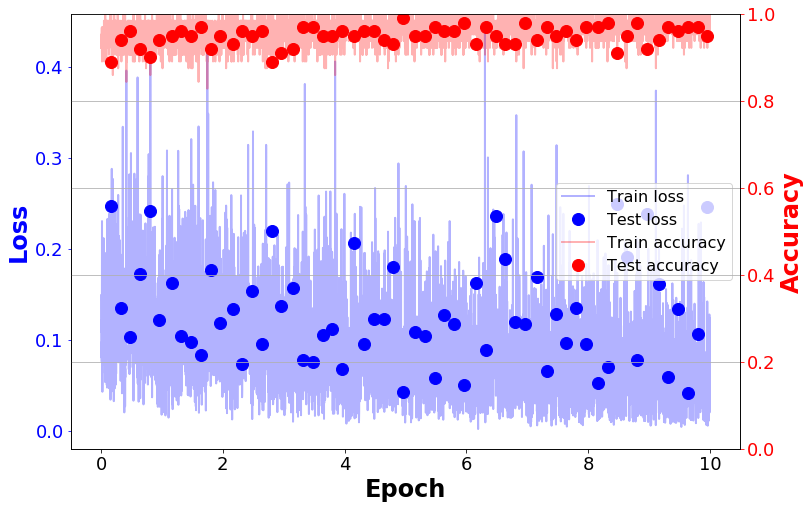

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

We see the loss is coming down while the accuracy is increasing. These two should be anti-correlated, so this is expected. We also see the network performance on the test dataset (circles) follow those of train dataset (lines). This means there is no apparent overtraining.

**Question: is the network still learning?**
Both the loss and accuracy curve have large fluctuations and it is somewhat hard to see if the values are still changing. Let's plot the moving average of the loss and accuracy values.

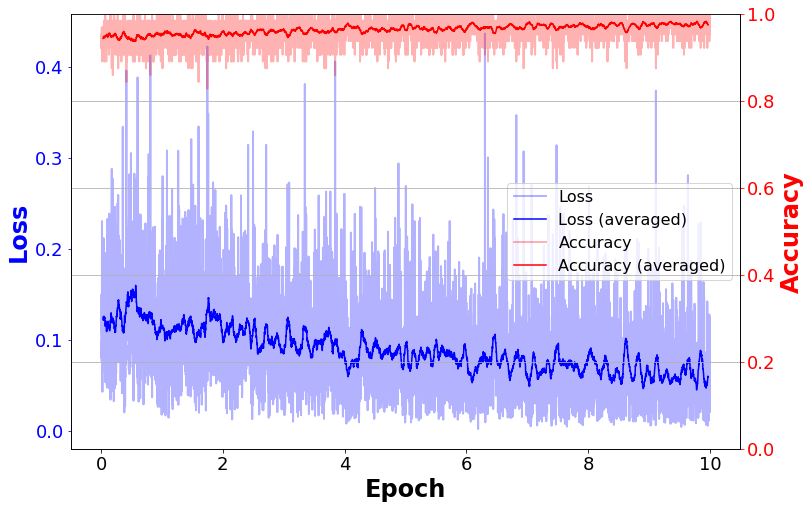

In [20]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

epoch    = moving_average(np.array(train_log.epoch),40)
accuracy = moving_average(np.array(train_log.accuracy),40)
loss     = moving_average(np.array(train_log.loss),40)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Loss', color='b', alpha=0.3)
line12 = ax1.plot(epoch, loss, label='Loss (averaged)', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Accuracy', color='r', alpha=0.3)
line22 = ax2.plot(epoch, accuracy, label='Accuracy (averaged)', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()


The tick lines now represent the moving average (all data points are from the train log). It appears the network is still learning. We can train for a longer period to achieve a better accuracy.

## Performance Analysis
Beyond looking at the performance of the network, we can analyze how the network is performing for each classification target. Let's first obtain a high-statistics analysis output by running the network on all test samples.

In [36]:
def inference(blob,data_loader):
    label,prediction,accuracy=[],[],[]
    energies,directions,charges,positions=[],[],[],[]
    idx,event_index,file_index=[],[],[]
    # set the network to test (non-train) mode
    blob.net.eval()
    # create the result holder
    index,label,prediction = [],[],[]
    for i,data in enumerate(data_loader):
        #blob.data, blob.label = data[0:2]
        #blob.pids, blob.energies, blob.positions, blob.directions = data[2:4]
        #print(len(data))
        blob.data, blob.label, blob.pids,blob.energies, blob.positions, blob.directions,tidx,tindex,findex = data

        #print(tindex)
        
        idx.append(tidx)
        event_index.append(tindex)
        file_index.append(findex)

        #tidx = data.idx;
        #tentry_index = data[6:2]
        #print(tidx.shape)
        # calculate the total charge for each event.
        #print(blob.data)
        for x in xrange(blob.data.shape[0]):
            total_charge = blob.data[x,:,:,0].reshape([-1])
            charges.append(total_charge.sum())
            
        res = forward(blob,True)
        accuracy.append(res['accuracy'])
        prediction.append(res['prediction'])
        label.append(blob.label)
        
        #energies.append(blob.energies)
        for i in xrange(len(blob.energies)):
            energies.append(blob.energies[i][0])
            directions.append(blob.directions[i][0])
            positions.append(blob.positions[i][0])


            
        #if i==2: break
    # report accuracy
    accuracy   = np.array(accuracy,dtype=np.float32)
    label      = np.hstack(label)
    prediction = np.hstack(prediction)
    energies   = np.array(energies)
    directions = np.array(directions)
    positions = np.array(positions)

    charges = np.array(charges)
    idx = np.hstack(idx)
    event_index = np.hstack(event_index)
    file_index = np.hstack(file_index)


    print(file_index.shape)
    
    return accuracy, label, prediction, energies, directions,charges, idx,event_index,file_index,positions

Let's run the inference using this function on the test sample, and look at the error matrix.

(59999,)
Accuracy mean 0.95378244 std 0.021676254


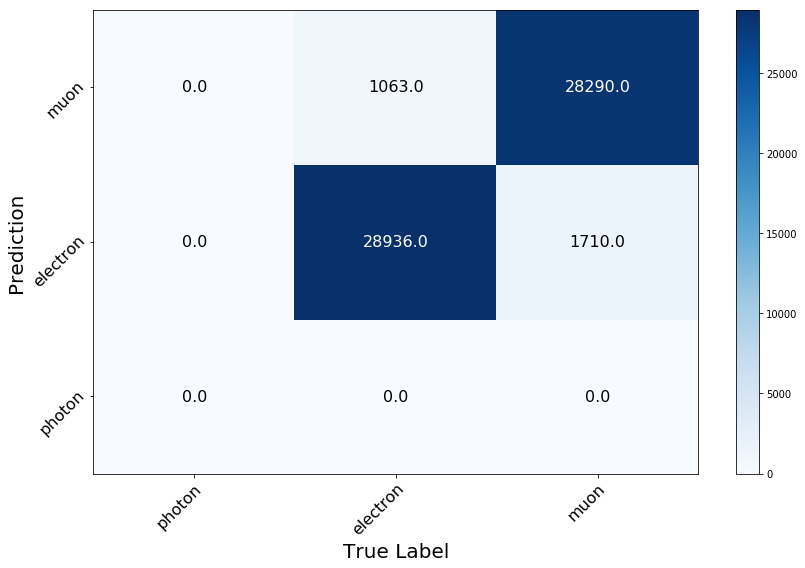

In [37]:
from utils import plot_confusion_matrix
accuracy,label,prediction,energies,directions,charges,idx,eindex,findex,positions = inference(blob,test_loader)
print('Accuracy mean',accuracy.mean(),'std',accuracy.std())

plot_confusion_matrix(label,prediction,['photon','electron','muon'])


As one may expect, muon is distinguished fairly well while there is some confusion between electron and gamma ray.

Accuracy mean 0.95378244 std 0.021676254
(600,)
(59999,)
(59999,)
(59999,)
(59999, 3)
(59999,)


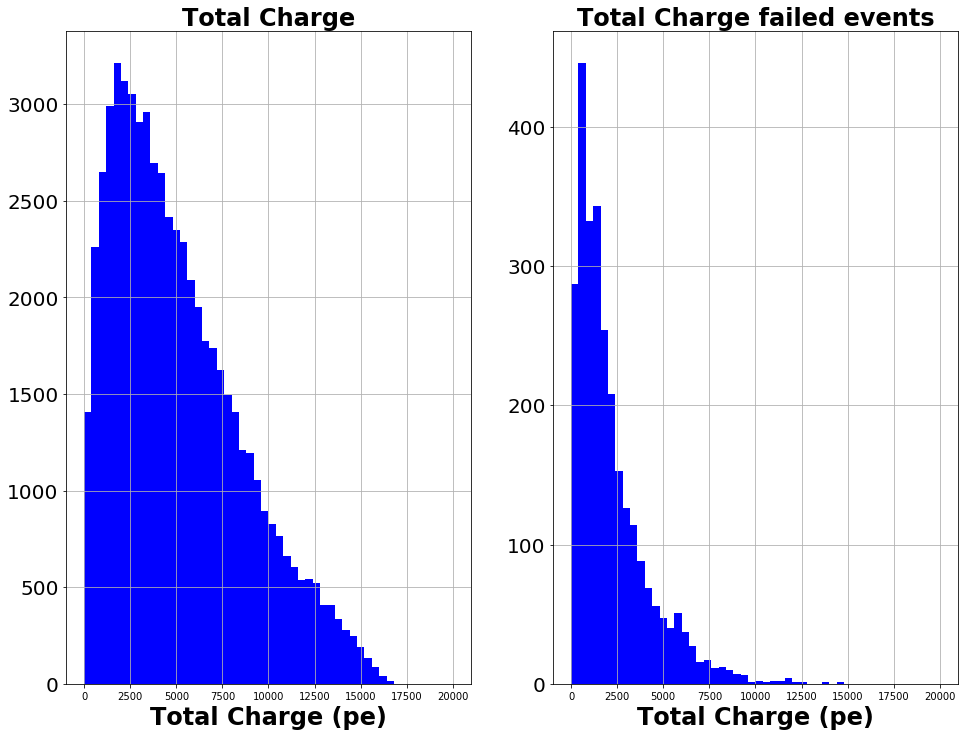

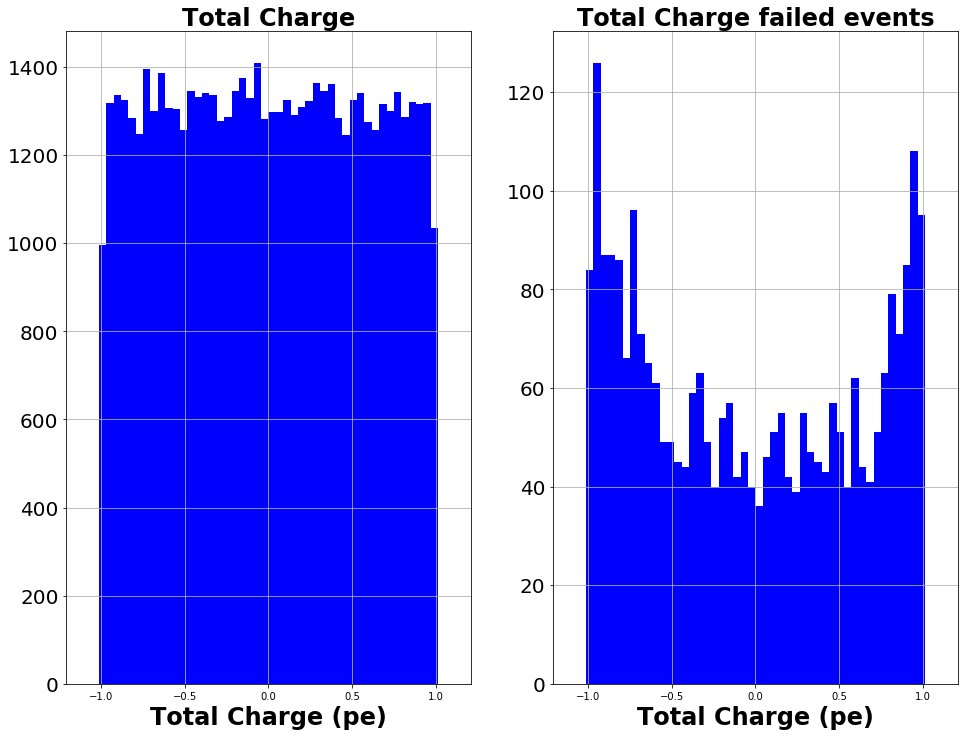

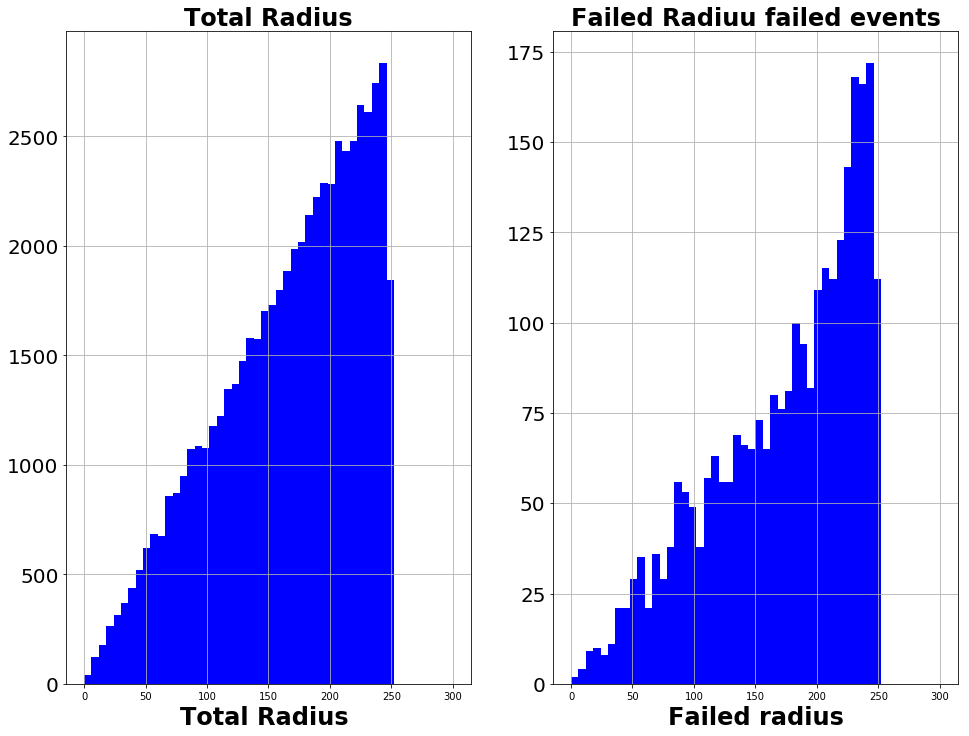

In [42]:
import numpy as np
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import math

print('Accuracy mean',accuracy.mean(),'std',accuracy.std())
print(accuracy.shape)
print(label.shape)

print(prediction.shape)
print(energies.shape)
print(directions.shape)
print(charges.shape)

fail_charge = []
all_direction = []
fail_direction = []
all_radius = []
fail_radius = []



sum = 0

fails = []
fails2 = []

#print(energies.shape,directions.shape)
for i,lab in enumerate(label):

    rr = math.sqrt(positions[i][0]*positions[i][0] + positions[i][2]*positions[i][2])

    all_direction.append(directions[i][1])
    all_radius.append(rr)
    if lab != prediction[i] :
        
        fail_charge.append(charges[i])
        fail_direction.append(directions[i][1])
        fail_radius.append(rr)
        
        #if sum < 100: 
        #    print("Failed ***",idx[i],eindex[i],findex[i])
        if sum < 100  and findex[i] == 0: 
            fails.append(eindex[i])
            sum = sum + 1

        
        if sum < 100 and findex[i] == 1: 
            #print("Failed ***",idx[i],eindex[i],findex[i])
            fails2.append(eindex[i])
            sum = sum + 1

        
        X = 0
        
        
#print(label[0], prediction[0])
##print(fails);
#print(fails2);



fail_charge = np.array(fail_charge)

fig,ax = plt.subplots(1,2,figsize=(16,12),facecolor='w')

ax[0].hist(charges,bins=50,range=(0,20000),color='blue',label='PMT Hit Timing')
ax[0].set_title("Total Charge",fontsize=24,fontweight='bold')
ax[0].set_xlabel('Total Charge (pe)',fontsize=24,fontweight='bold')
ax[0].tick_params('x',labelsize=10)
ax[0].tick_params('y',labelsize=20)
ax[0].grid()
ax[1].hist(fail_charge,bins=50,range=(0,20000),color='blue',label='PMT Hit Timing')
ax[1].set_title("Total Charge failed events",fontsize=24,fontweight='bold')
ax[1].set_xlabel('Total Charge (pe)',fontsize=24,fontweight='bold')
ax[1].tick_params('x',labelsize=10)
ax[1].tick_params('y',labelsize=20)
ax[1].grid()


fail_direction = np.array(fail_direction)
all_direction = np.array(all_direction)

fig2,ax2 = plt.subplots(1,2,figsize=(16,12),facecolor='w')

ax2[0].hist(all_direction,bins=50,range=(-1.1,1.1),color='blue',label='PMT Hit Timing')
ax2[0].set_title("Total Charge",fontsize=24,fontweight='bold')
ax2[0].set_xlabel('Total Charge (pe)',fontsize=24,fontweight='bold')
ax2[0].tick_params('x',labelsize=10)
ax2[0].tick_params('y',labelsize=20)
ax2[0].grid()
ax2[1].hist(fail_direction,bins=50,range=(-1.1,1.1),color='blue',label='PMT Hit Timing')
ax2[1].set_title("Total Charge failed events",fontsize=24,fontweight='bold')
ax2[1].set_xlabel('Total Charge (pe)',fontsize=24,fontweight='bold')
ax2[1].tick_params('x',labelsize=10)
ax2[1].tick_params('y',labelsize=20)
ax2[1].grid() 


fail_radius = np.array(fail_radius)
all_radius = np.array(all_radius)

fig2,ax2 = plt.subplots(1,2,figsize=(16,12),facecolor='w')

ax2[0].hist(all_radius,bins=50,range=(0,300),color='blue',label='PMT Hit Timing')
ax2[0].set_title("Total Radius",fontsize=24,fontweight='bold')
ax2[0].set_xlabel('Total Radius ',fontsize=24,fontweight='bold')
ax2[0].tick_params('x',labelsize=10)
ax2[0].tick_params('y',labelsize=20)
ax2[0].grid()
ax2[1].hist(fail_radius,bins=50,range=(0,300),color='blue',label='PMT Hit Timing')
ax2[1].set_title("Failed Radiuu failed events",fontsize=24,fontweight='bold')
ax2[1].set_xlabel('Failed radius',fontsize=24,fontweight='bold')
ax2[1].tick_params('x',labelsize=10)
ax2[1].tick_params('y',labelsize=20)
ax2[1].grid() 






#_ = plt.hist(fail_charge,bins=50)






Now plot the failed classification

<class 'h5py._hl.files.File'>
[u'directions', u'energies', u'event_data', u'labels', u'pids', u'positions']
(99999, 88, 168, 2)
(99999, 1, 3)
(99999, 1)


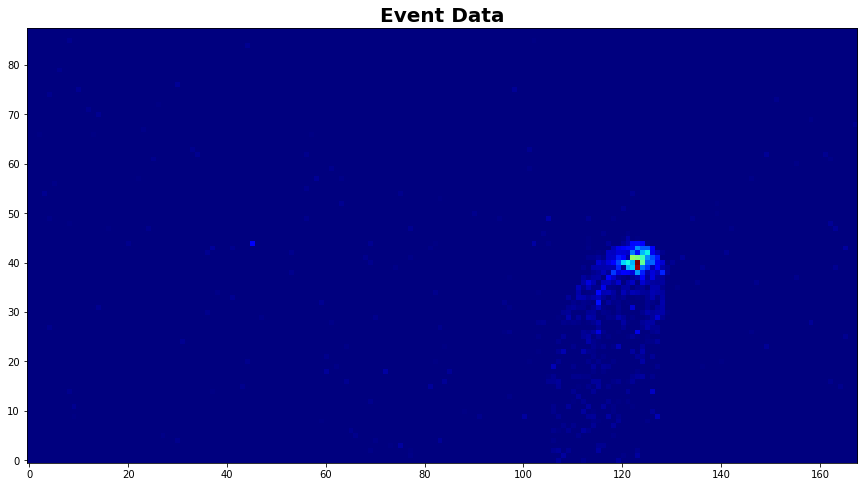

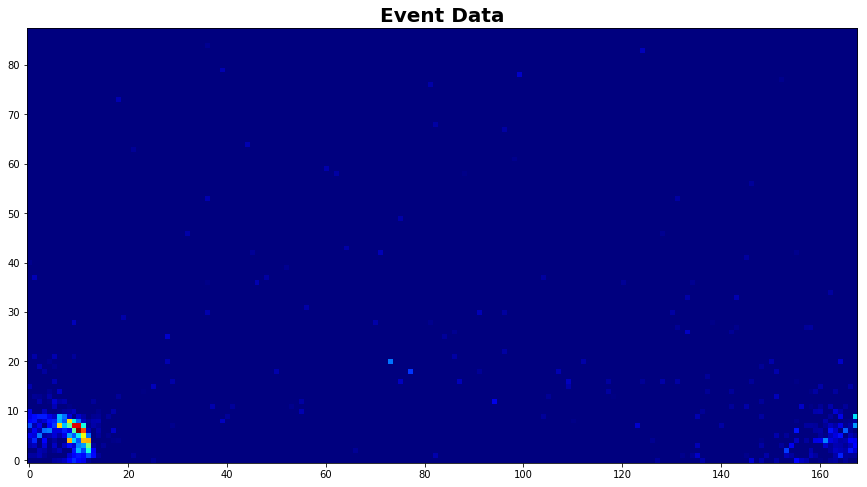

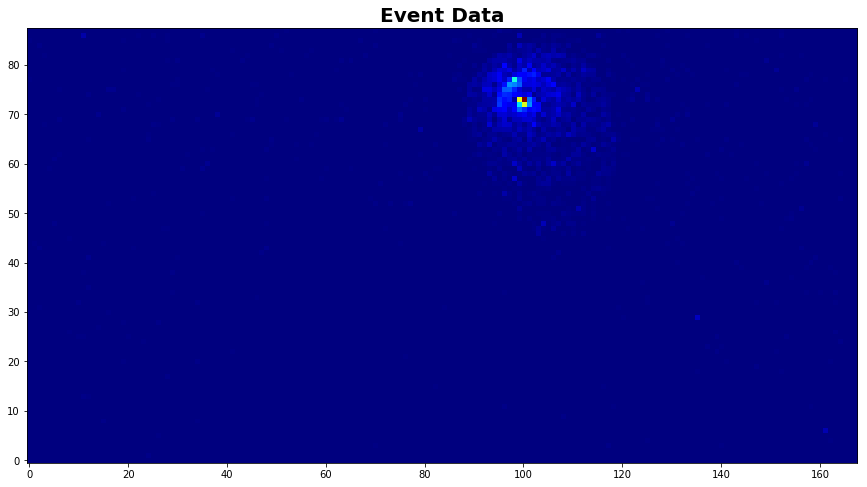

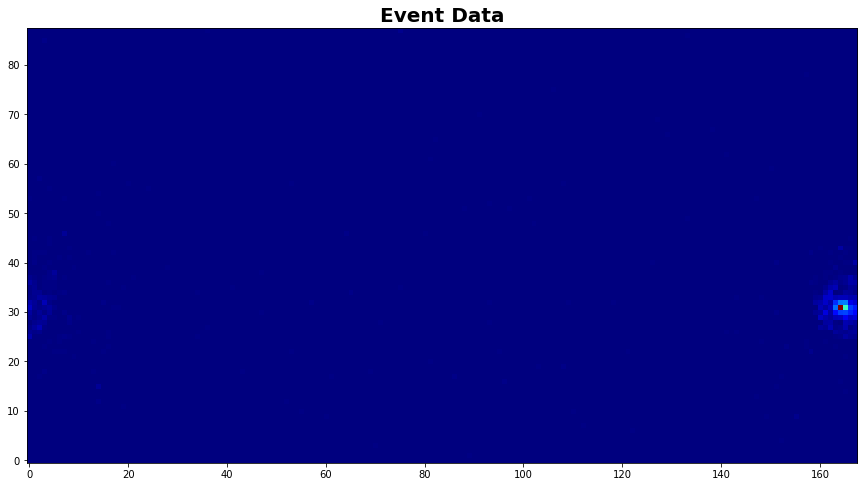

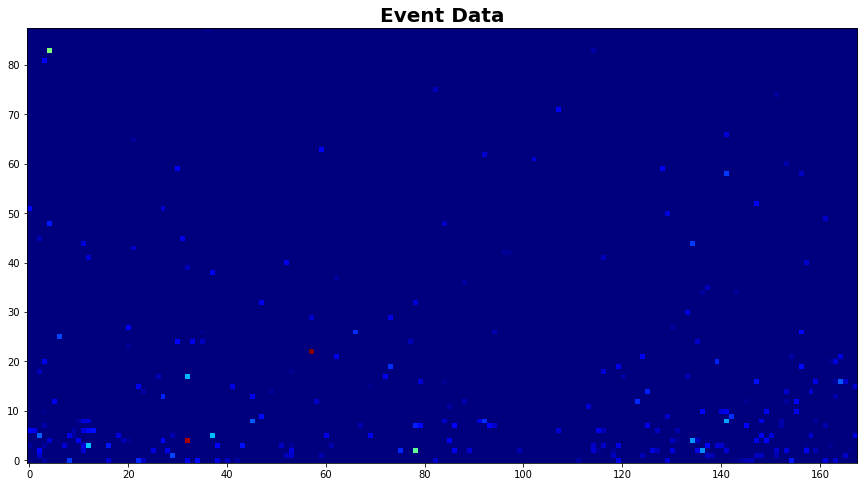

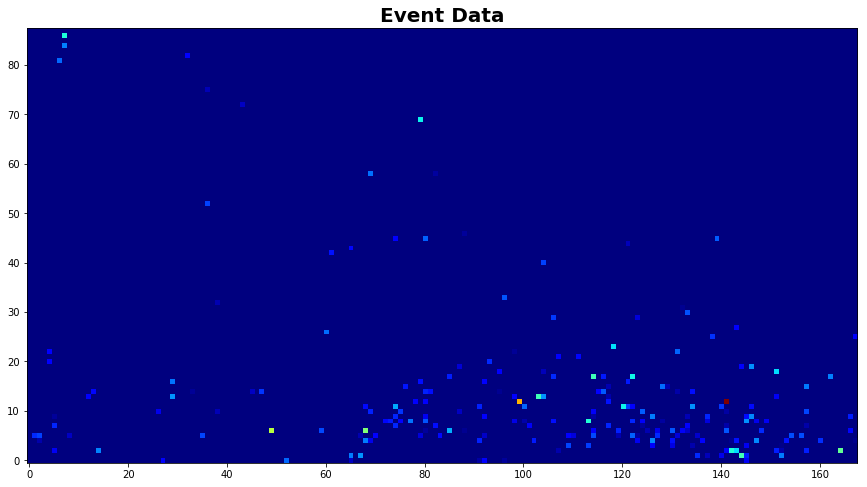

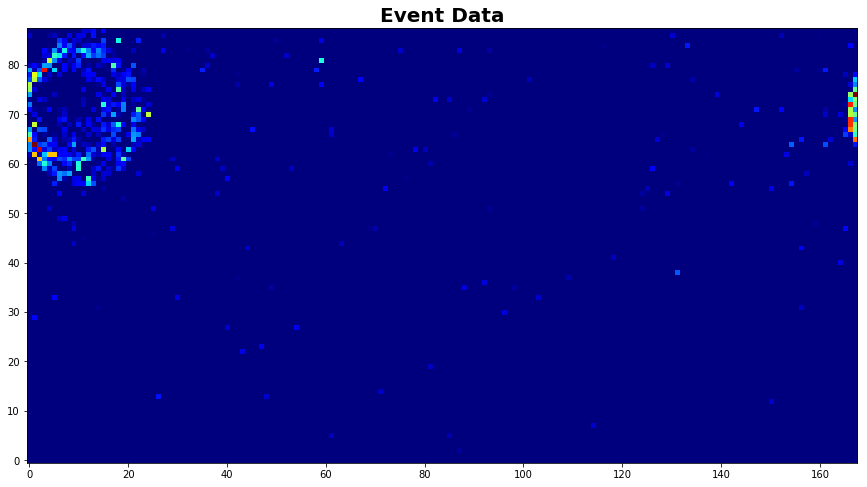

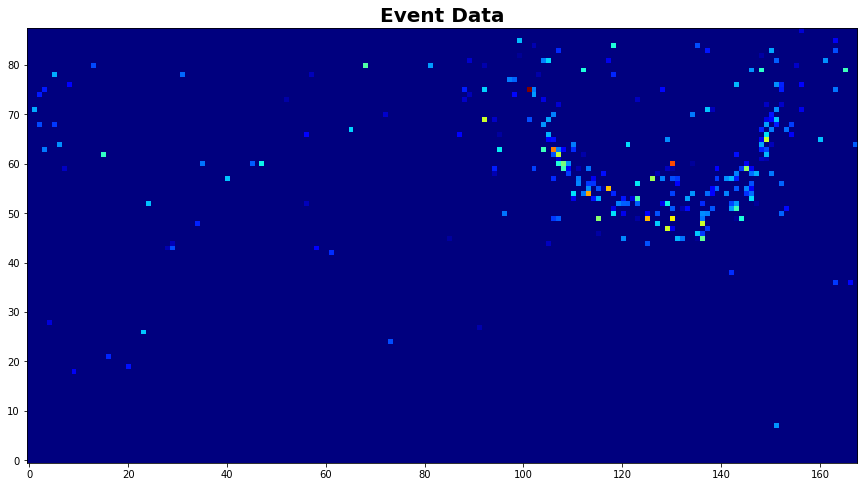

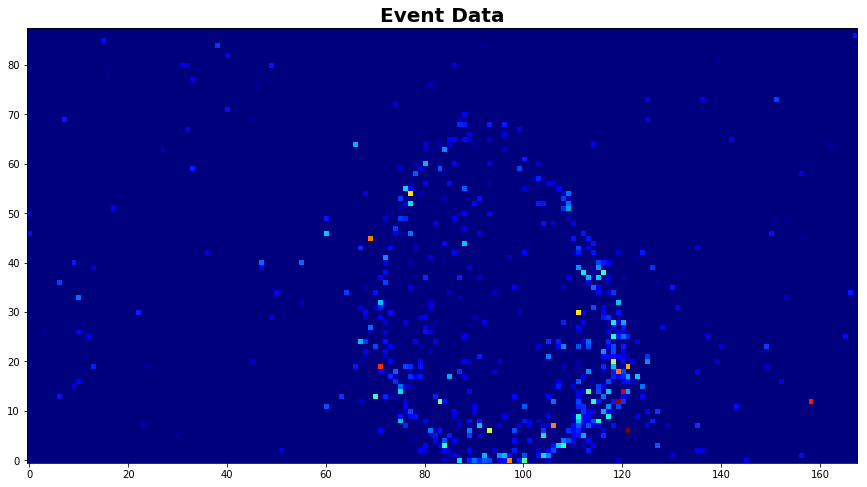

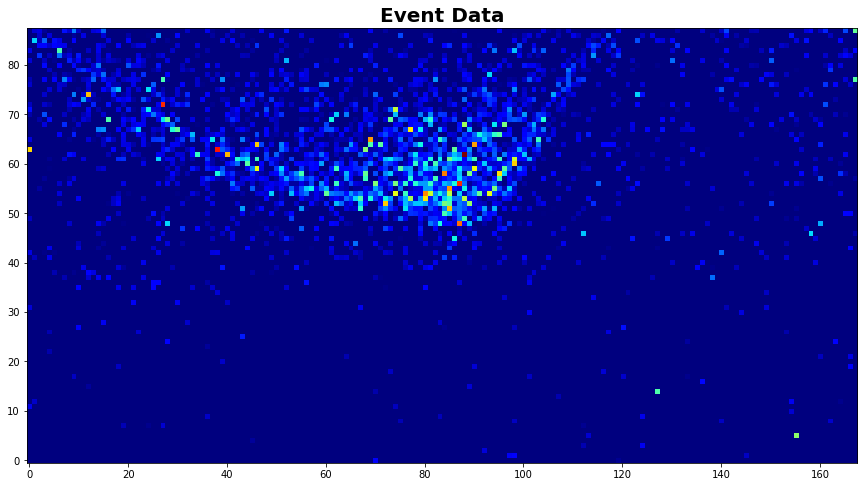

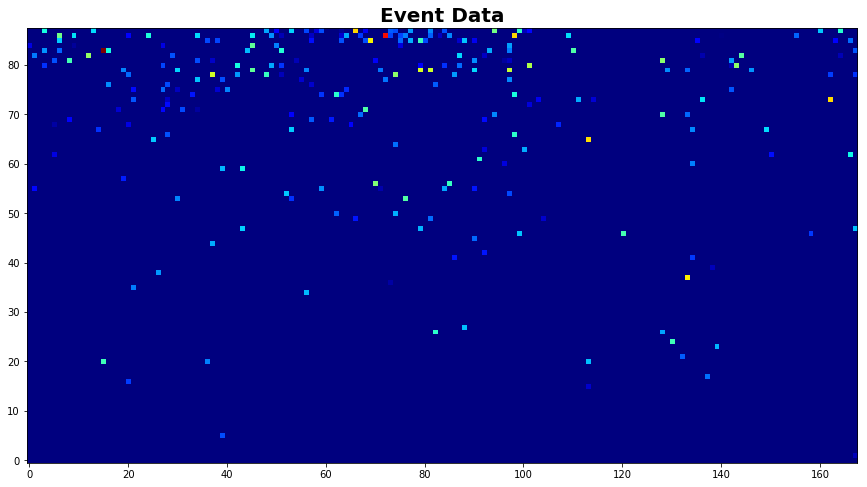

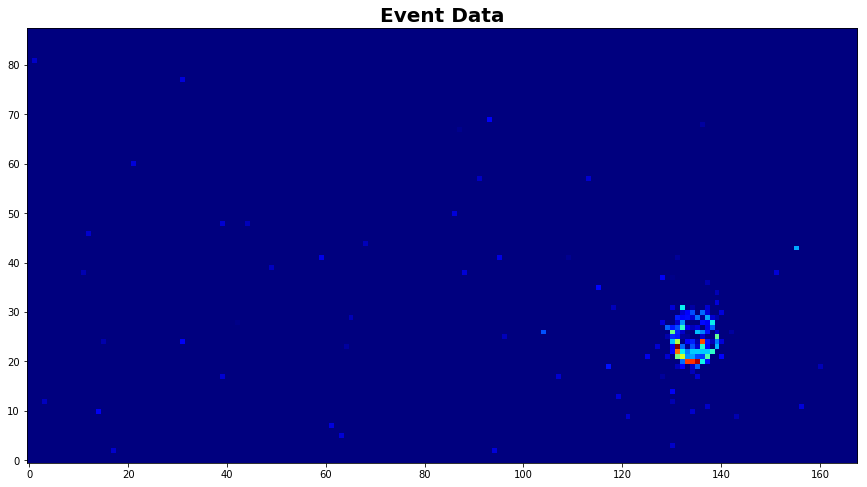

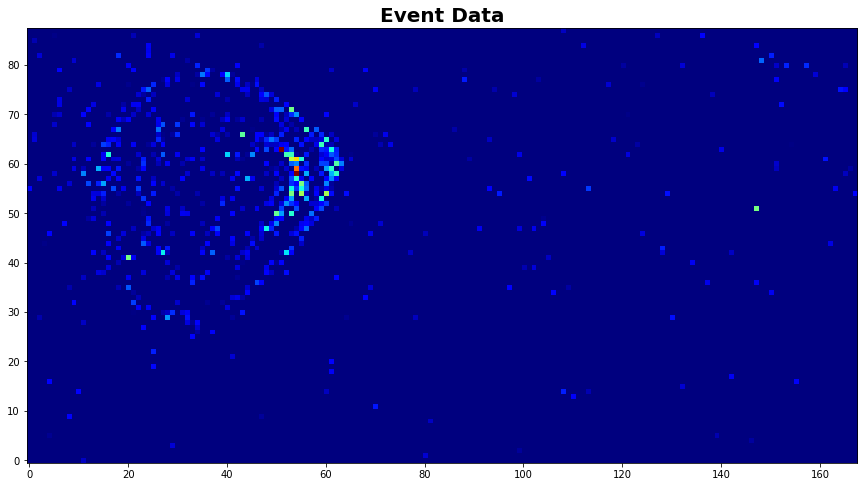

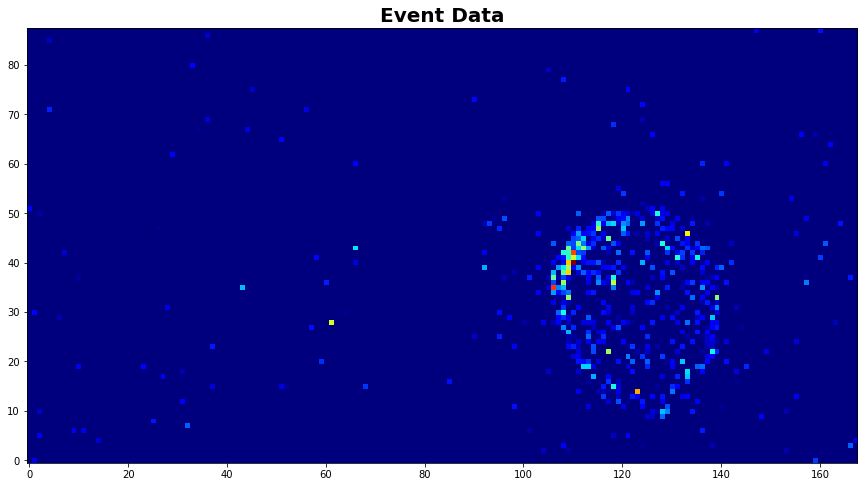

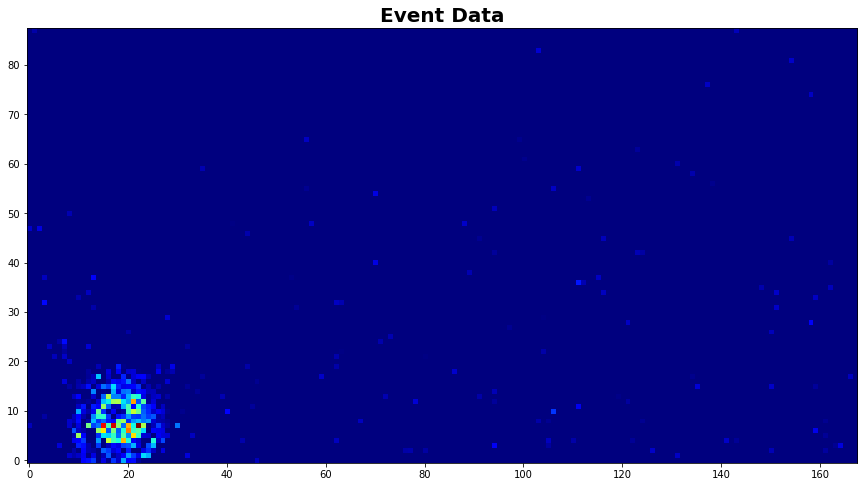

In [12]:
import numpy as np
from __future__ import print_function

# Change if you want to open a different file
#DATA_FILE_PATH='/data/hkml_data/IWCDgrid/varyE/e-/IWCDgrid_varyE_e-_R0cm_20-2000MeV_100evts_1.npz'
DATA_FILE_PATH='/data/hkml_data/IWCDgrid/varyAll/e-/IWCDgrid_varyAll_e-_20-2000MeV_100k.h5'
#DATA_DIRS=['/data/hkml_data/IWCDgrid/varyAll/e-','/data/hkml_data/IWCDgrid/varyAll/mu-']

# Open file
#f = np.load(DATA_FILE_PATH)
import h5py
f = h5py.File(DATA_FILE_PATH,mode='r')
    
# Print the object type
print (type(f))

print (f.keys())

print (f['event_data'].shape)
print (f['positions'].shape)
print (f['energies'].shape)

import matplotlib.pyplot as plt
%matplotlib inline


failed_events = [37689, 30123, 34090, 35692, 36672, 31871, 36885, 38808, 39189, 34685, 35529, 31861, 35429, 38174, 33101]
failed_events2 = [27818,27936,28740,20663,27074]

#Failed *** 12956 32957 1
#Failed *** 5962 35961 0
#Failed *** 1808 31807 0
#Failed *** 2459 32458 0
#Failed *** 16370 36371 1
#Failed *** 134 30133 0
#Failed *** 16069 36070 1
#Failed *** 8645 38644 0


#Failed *** 7819 27818
#Failed *** 17935 27936
#Failed *** 8741 28740
#Failed *** 10662 20663
#Failed *** 17073 27074
#Failed *** 9810 29809
#Failed *** 13586 23587
#Failed *** 3967 23966
#Failed *** 11576 21577
#Failed *** 14522 24523
#Failed *** 736 20735
#Failed *** 267 20266

for idx in failed_events:
    
    fig, ax = plt.subplots(figsize=(16,8),facecolor='w')
    plt.imshow(f['event_data'][idx,:,:,0],cmap='jet',origin='lower')
    ax.set_title('Event Data',fontsize=20,fontweight='bold')
    plt.show()
    
f.close()

kljkl